# Тестирование модели

In [1]:
import pandas as pd
from matplotlib import pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


c:\users\asyarita\appdata\local\programs\python\python39\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
import os

path = 'kaggle_data' 

UnpreparedData, Data = [], []
Names = []

def read_files(comma):
    for directory in os.listdir(path):
        directory_path = os.path.join(path, directory)
        if os.path.isfile(directory_path):
            with open(directory_path, 'r') as file_name:
                try:
                    df = pd.read_csv(file_name, delimiter=comma)
                    if df.shape[1] == 5:
                        Names.append(str(file_name).split('_')[-1].split('.')[0])
                        UnpreparedData.append(df.iloc[:-1])
                except:
                    pass

read_files(';')
read_files(',')

Names = [int(Names[i]) for i in range(len(Names))]
len(UnpreparedData), len(Names)

(146, 146)

In [3]:
import copy

Data = copy.deepcopy(UnpreparedData)
len(Data)

146

In [4]:
data = pd.DataFrame()

In [5]:
for i in range(len(Data)):
    try:
        Data[i]['time']
    except KeyError:
        try:
            Data[i]['utime']
            Data[i].rename(columns={'utime': 'time'}, inplace=True)
        except:
            headers = Data[i].iloc[0]
            Data[i] = pd.DataFrame(Data[i].values[1:], columns=headers)

In [6]:
def get_amplitude(df):
    acceleration = (df.gFx ** 2 + df.gFy ** 2 + df.gFz ** 2) ** 0.5
    return acceleration.max() - acceleration.min()

def get_frequency(df):
    return df[df['time'] <= 1.0].shape[0]

def process_data(df, i):
    df = df.applymap(lambda x: str(x).replace(',', '.'))
    # приведение time к общему формату
    if str(df.iloc[0]['time']).find(':') != -1:
        df['time'] = df['time'].apply(lambda x: x.split(':')[-1])
        current_time = float(df.iloc[0]['time'])
        df['time'] = df['time'].apply(lambda x: (float(x) - current_time + 60) % 60)
    
    df['time'] = df['time'].astype(float)
    df['gFx'] = df['gFx'].astype(float)
    df['gFy'] = df['gFy'].astype(float)
    df['gFz'] = df['gFz'].astype(float)
    
    # получение частоты сбора данных
    freq = get_frequency(df)
    freq -= freq % 10    # округление    
    # обрезка начала и конца данных
    time = df.shape[0] // freq    # количество секунд в треке
    # оставляем только 10 секунд середины, так как некоторые треки очень короткие
    start = (time - 10) // 2 * freq
    end = -(time - 10) // 2 * freq    
    df = df[start:end]
    
    return df, get_amplitude(df), freq
    
Amplitude = []
Frequency = [] # для FFT
for i in range(len(Data)):
    Data[i], amplitude, frequency = process_data(Data[i], i)
    Amplitude.append(amplitude)
    Frequency.append(frequency)

len(Amplitude), len(Frequency)

(146, 146)

In [7]:
# добавление характеристик Amplitude и Frequency
data['Amplitude'] = Amplitude
data['Frequency'] = Frequency
data.shape

(146, 2)

In [8]:
# преобразуем основные данные
valid = [i for i in range(len(Data)) if not (math.isnan(Amplitude[i]) or 
                                             Amplitude[i] == -1 or 
                                             Frequency == -1)]
Data = [Data[i] for i in valid]
Amplitude = [Amplitude[i] for i in valid]
Frequency = [Frequency[i] for i in valid]

# преобразуем таблицу
data = data[(data['Amplitude'].notna()) & 
            (data['Amplitude'] != -1) & 
            (data['Frequency'] != -1)]
len(Data), len(Amplitude), len(Frequency), data.shape

(146, 146, 146, (146, 2))

In [9]:
# поиск матрицы поворота
def rotation_matrix_from_vectors(vec1, vec2):
    norm_vec1 = (vec1 / numpy.linalg.norm(vec1)).reshape(3)
    norm_vec2 = (vec2 / numpy.linalg.norm(vec2)).reshape(3)
    cross_prod = numpy.cross(norm_vec1, norm_vec2)
    if any(cross_prod):
        scalar_prod = numpy.dot(norm_vec1, norm_vec2)
        cross_prod_norm = numpy.linalg.norm(cross_prod)
        k_mat = numpy.array([[0, -cross_prod[2], cross_prod[1]], 
                            [cross_prod[2], 0, -cross_prod[0]], 
                            [-cross_prod[1], cross_prod[0], 0]])
        return numpy.eye(3) + k_mat + k_mat.dot(k_mat) * ((1 - scalar_prod) / (cross_prod_norm ** 2))
    else:
        return numpy.eye(3)

# получение новых координат
def rotate(X, Y, Z, matrix):
    new_x, new_y, new_z = [], [], []
    for coord in zip(X, Y, Z):
        res = matrix.dot(coord)
        new_x.append(res[0])
        new_y.append(res[1])
        new_z.append(res[2])
    return new_x, new_y, new_z

# новые координаты
NewData = []
for df in Data:
    # вычисляем средний вектор ускорения по треку
    m_x = df['gFx'].values.mean() 
    m_y = df['gFy'].values.mean() 
    m_z = df['gFz'].values.mean() 
    # находим матрицу поворота
    vec1 = [m_x, m_y, m_z]
    vec2 = [0, 0, 1]
    matrix = rotation_matrix_from_vectors(vec1, vec2)
    # находим новые координаты
    new_x, new_y, new_z = rotate(df['gFx'].values, 
                                 df['gFy'].values, 
                                 df['gFz'].values, 
                                 matrix)
    # добавляем новые координаты в NewData
    NewData.append(pd.DataFrame({'gFx': new_x, 'gFy': new_y, 'gFz': new_z}))

len(NewData)

146

In [10]:
import numpy as np

def integrate(arr):
    res = []
    s = 0
    for elem in arr:
        s += elem
        res.append(s)
    return res

def get_difference(arr):
    return max(arr) - min(arr)

Velocity = []
vel_amp = []
for i in range(len(NewData)):
    x = np.array([x_coord / Frequency[i] for x_coord in NewData[i]['gFx']])
    y = np.array([y_coord / Frequency[i] for y_coord in NewData[i]['gFy']])
    z = np.array([(z_coord - 1) / Frequency[i] for z_coord in NewData[i]['gFz']])
    acceleration = (x ** 2 + y ** 2 + z ** 2) ** 0.5
    
    # получение скорости
    Velocity.append(integrate(acceleration))
    # получение нужных характеристик
    vel_amp.append(get_difference(Velocity[i]))
    
data['VelocityAmplitude'] = vel_amp

len(vel_amp)

146

In [11]:
FFT_acc = []
for i in range(len(Data)):
    n = Data[i].shape[0]
    T = n / Frequency[i]
    
    # преобразование для данных по Acceleration
    f = (Data[i]['gFx'] ** 2 + Data[i]['gFy'] ** 2 + Data[i]['gFz'] ** 2) ** 0.5
    frq = (np.arange(n) / T)[:n // 2]
    F_acc = abs((np.fft.fft(f) / n)[:n // 2])
    
    # добавляем полученный результат в массив
    FFT_acc.append(F_acc)

In [12]:
X_max, Y_max = [], []
for i in range(len(Data)):
    ind = np.argmax(np.array(FFT_acc[i][1:])) + 1
    n = Data[i].shape[0]
    T = n / Frequency[i]  
    # добавляем значения в массив
    X_max.append((np.arange(n) / T)[ind])
    Y_max.append(FFT_acc[i][ind])
    
data['X_max'] = X_max
data['Y_max'] = Y_max

Отсортируем данные по названию трека

In [13]:
data['Names'] = Names
data['Names'] = data['Names'].astype(int)
data.sort_values(by=['Names'], inplace=True)

# Получение предсказания

### Предсказание на 70.5%

In [ ]:
def get_prediction_1(df):
    if (df['Amplitude'] < 0.35) and (df['Y_max'] < 0.03):
        return 0 #стояние
    if (df['Amplitude'] > 3) and (df['Y_max'] > 0.15) and (df['VelocityAmplitude'] > 8):
        return 2 #бег
    if df['Y_max'] < 0.01:
        return 6 # метро
    if (df['Y_max'] < 0.02) and (df['Amplitude'] < 2):
        return 5 # автомобиль
    if (df['X_max'] > 4.5) and (df['Y_max'] < 0.06):
        return 7 # электросамокат
    if ((df['X_max'] < 1) or (df['X_max'] > 2.5)) and (df['Y_max'] < 0.15):
        return 3 # велосипед
    if (df['Y_max'] < 0.1) and (df['VelocityAmplitude'] < 5.5):
        return 4 # лестница
    return 1 #ходьба


prediction = data.apply(lambda x: get_prediction_1(x), axis=1)

Res = pd.DataFrame({'track_num' : data['Names'], 'action' : prediction})
Res.to_csv("prediction_1.csv", index=False)

### Предсказание на 72.6%

In [ ]:
def get_prediction_2(df):
    if (df['Names'] in [32, 34, 38, 46, 56, 59, 71, 101, 113, 142, 143]):
        if df['Y_max'] < 0.01:
            return 6 # метро
        if (df['Y_max'] < 0.02) and (df['Amplitude'] < 2):
            return 5 # автомобиль
        if (df['X_max'] > 4.5) and (df['Y_max'] < 0.06):
            return 7 # электросамокат
        return 8 # самокат
    
    if (df['Amplitude'] < 0.3) and (df['Y_max'] < 0.02):
        return 0 #стояние
    if (df['Amplitude'] > 3) and (df['Y_max'] > 0.15) and (df['VelocityAmplitude'] > 8):
        return 2 #бег
    if ((df['X_max'] < 1) or (df['X_max'] > 2.5)) and (df['Y_max'] < 0.15):
        return 3 # велосипед
    if (df['Amplitude'] < 3.5) and (df['Y_max'] < 0.1) and (df['VelocityAmplitude'] < 5.5):
        return 4 # лестница
    return 1 #ходьба


prediction = data.apply(lambda x: get_prediction_2(x), axis=1)

Res = pd.DataFrame({'track_num' : data['Names'], 'action' : prediction})
Res.to_csv("prediction_2.csv", index=False)

### Предсказание на 73.3%

In [14]:
def get_prediction(df):
    if (df['Names'] in [32, 34, 38, 46, 56, 59, 71, 101, 113, 142, 143]):
        if df['Y_max'] < 0.01:
            return 6 # метро
        if (df['Y_max'] < 0.02) and (df['Amplitude'] < 2):
            return 5 # автомобиль
        if (df['X_max'] > 4.5) and (df['Y_max'] < 0.06):
            return 7 # электросамокат
        return 8 # самокат
    
    if (df['Amplitude'] < 0.35) and (df['Y_max'] < 0.03):
        return 0 #стояние
    if (df['Amplitude'] > 3) and (df['Y_max'] > 0.15) and (df['VelocityAmplitude'] > 8):
        return 2 #бег
    if ((df['X_max'] < 1) or (df['X_max'] > 2.5)) and (df['Y_max'] < 0.15):
        return 3 # велосипед
    if (df['Y_max'] < 0.1) and (df['VelocityAmplitude'] < 5.5):
        return 4 # лестница
    return 1 #ходьба


prediction = data.apply(lambda x: get_prediction(x), axis=1)

Res = pd.DataFrame({'track_num' : data['Names'], 'action' : prediction})
Res.to_csv("prediction.csv", index=False)

In [15]:
Res['action'].value_counts()

3    29
4    29
1    27
0    25
2    25
6     5
5     4
7     1
8     1
Name: action, dtype: int64

____________________________________________________________________________________________________


Amplitude              2.607838
Frequency            250.000000
VelocityAmplitude      7.763581
X_max                  1.775037
Y_max                  0.188077
Names                103.000000
Name: 6, dtype: float64

ACTION: 1


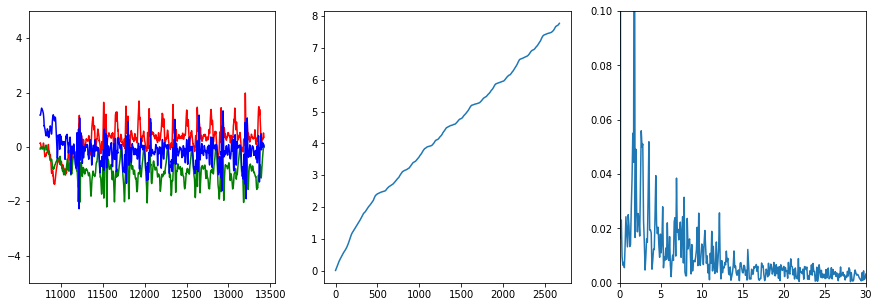

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude              1.892563
Frequency            400.000000
VelocityAmplitude      5.710700
X_max                  1.819009
Y_max                  0.084037
Names                108.000000
Name: 11, dtype: float64

ACTION: 1


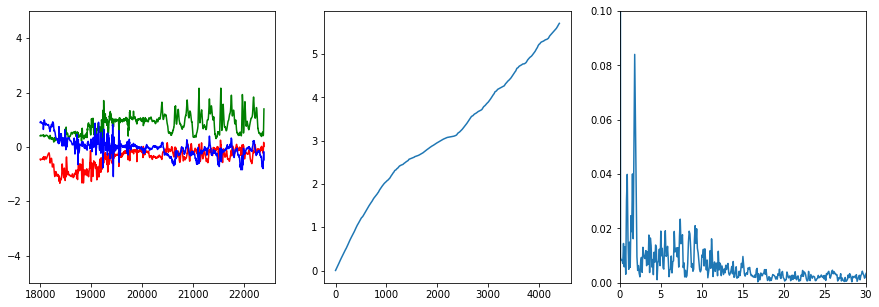

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude              3.579886
Frequency            250.000000
VelocityAmplitude     11.309349
X_max                  1.285093
Y_max                  0.036980
Names                 11.000000
Name: 13, dtype: float64

ACTION: 1


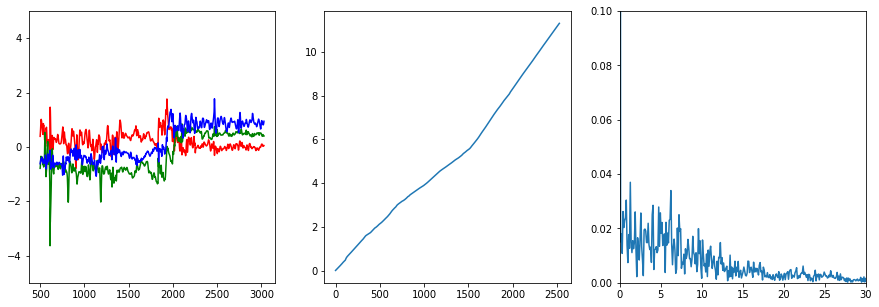

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude              1.858024
Frequency            250.000000
VelocityAmplitude      7.075388
X_max                  2.054795
Y_max                  0.039989
Names                110.000000
Name: 14, dtype: float64

ACTION: 1


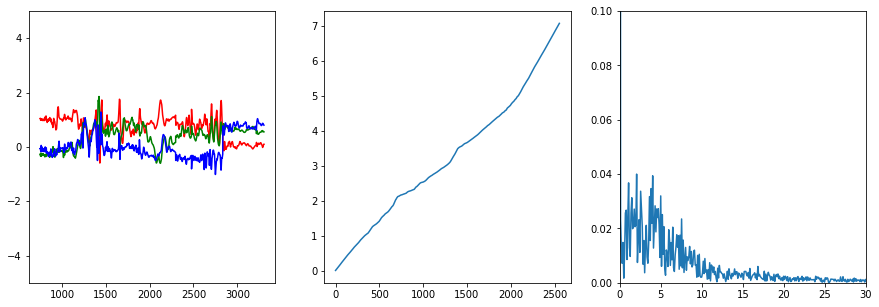

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude              1.482548
Frequency            100.000000
VelocityAmplitude      5.056827
X_max                  2.040816
Y_max                  0.146965
Names                112.000000
Name: 16, dtype: float64

ACTION: 1


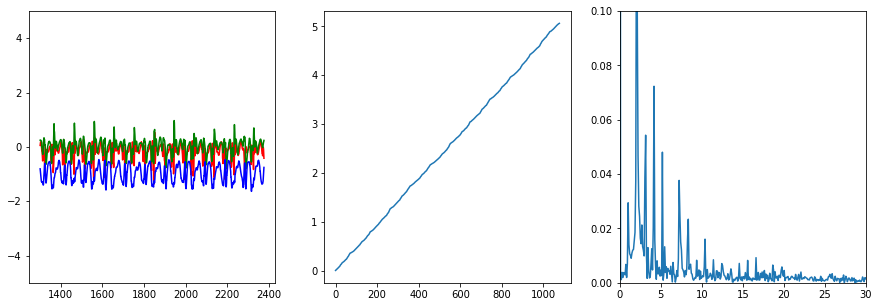

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude              2.933115
Frequency            100.000000
VelocityAmplitude      5.366085
X_max                  1.842871
Y_max                  0.156132
Names                116.000000
Name: 20, dtype: float64

ACTION: 1


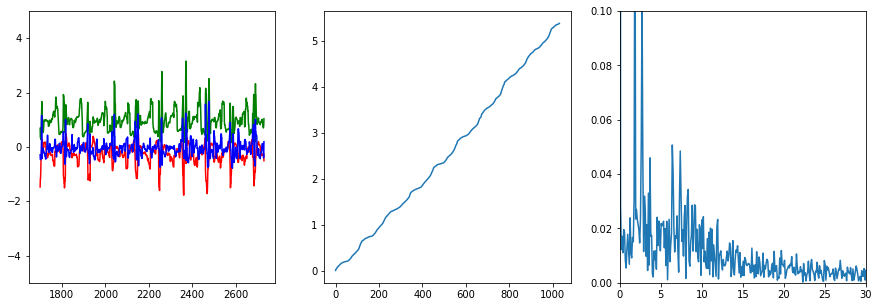

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude              2.271074
Frequency            100.000000
VelocityAmplitude      4.916178
X_max                  1.792829
Y_max                  0.162566
Names                124.000000
Name: 29, dtype: float64

ACTION: 1


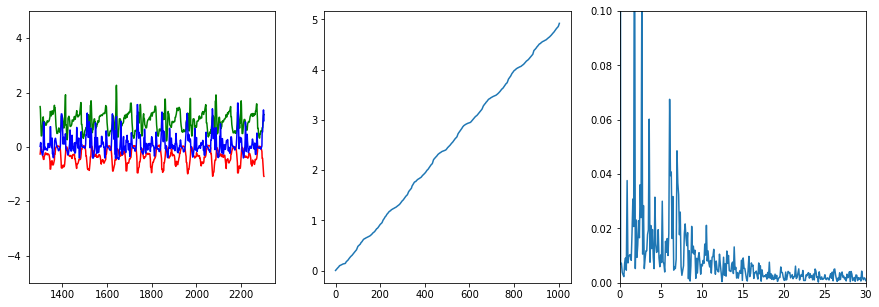

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude              2.134960
Frequency            250.000000
VelocityAmplitude      5.269009
X_max                  1.800607
Y_max                  0.254634
Names                126.000000
Name: 31, dtype: float64

ACTION: 1


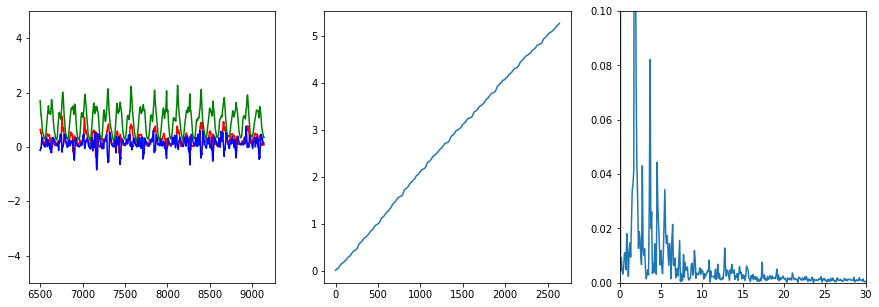

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude              3.058094
Frequency            390.000000
VelocityAmplitude      5.789113
X_max                  1.002102
Y_max                  0.134157
Names                128.000000
Name: 33, dtype: float64

ACTION: 1


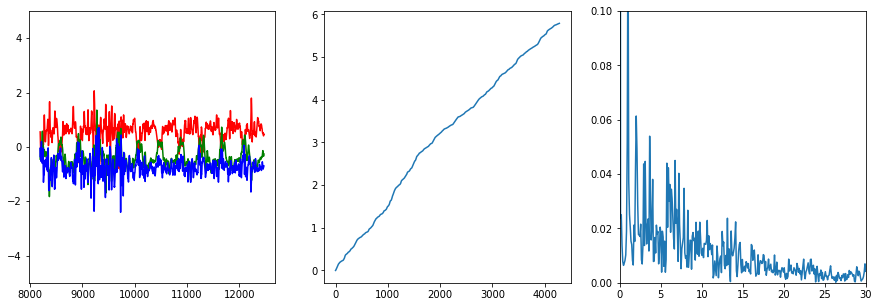

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude              2.166557
Frequency            390.000000
VelocityAmplitude      4.472140
X_max                  1.570997
Y_max                  0.125739
Names                131.000000
Name: 37, dtype: float64

ACTION: 1


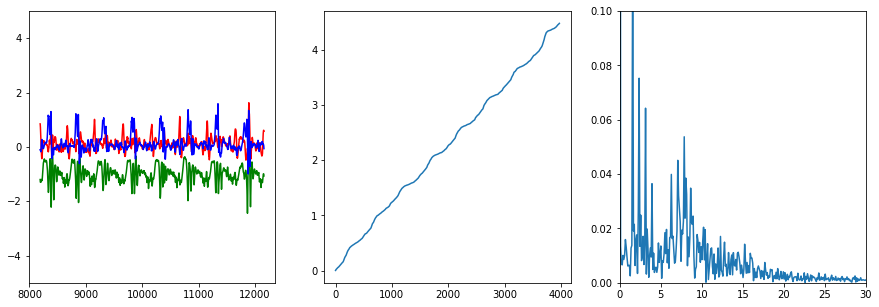

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude              2.645009
Frequency            500.000000
VelocityAmplitude      1.522573
X_max                  1.530612
Y_max                  0.145370
Names                133.000000
Name: 39, dtype: float64

ACTION: 1


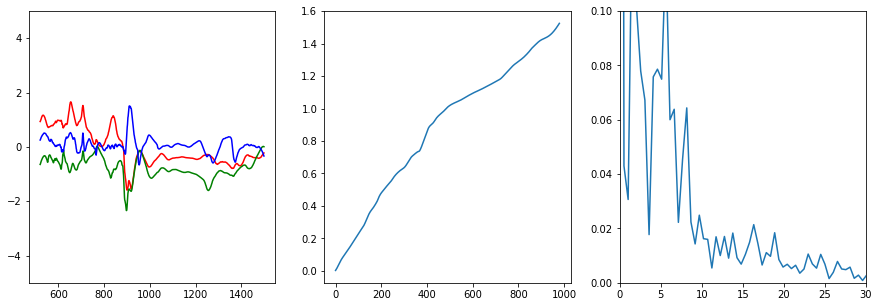

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude              4.238435
Frequency            500.000000
VelocityAmplitude      7.787936
X_max                  1.653804
Y_max                  0.175962
Names                135.000000
Name: 41, dtype: float64

ACTION: 1


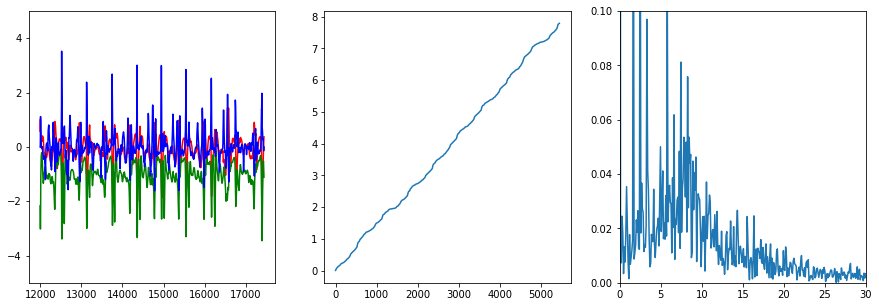

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude              3.218248
Frequency            100.000000
VelocityAmplitude      6.284340
X_max                  1.914312
Y_max                  0.130204
Names                137.000000
Name: 43, dtype: float64

ACTION: 1


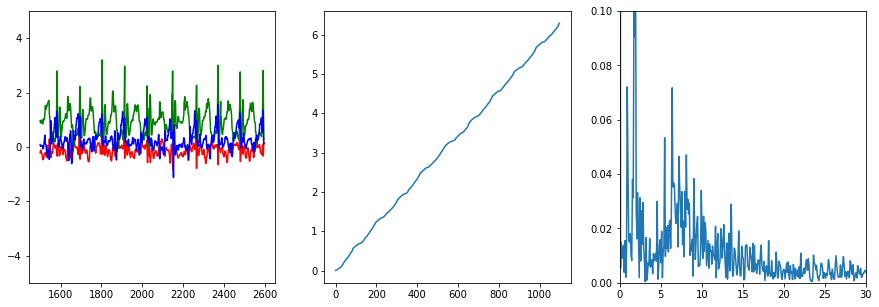

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude              2.418534
Frequency            100.000000
VelocityAmplitude      6.308586
X_max                  1.064860
Y_max                  0.054196
Names                 14.000000
Name: 46, dtype: float64

ACTION: 1


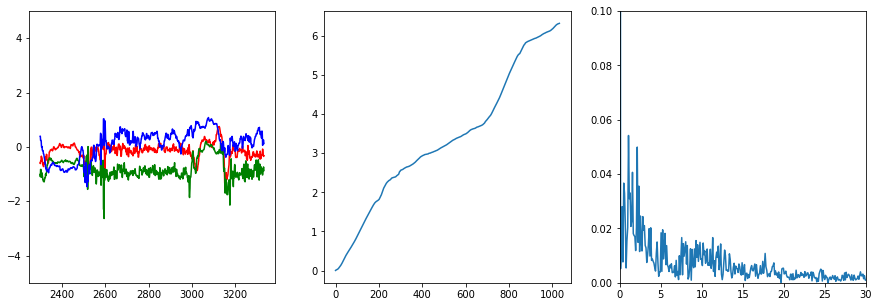

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude              3.132351
Frequency            190.000000
VelocityAmplitude      5.805399
X_max                  1.542364
Y_max                  0.087107
Names                 16.000000
Name: 54, dtype: float64

ACTION: 1


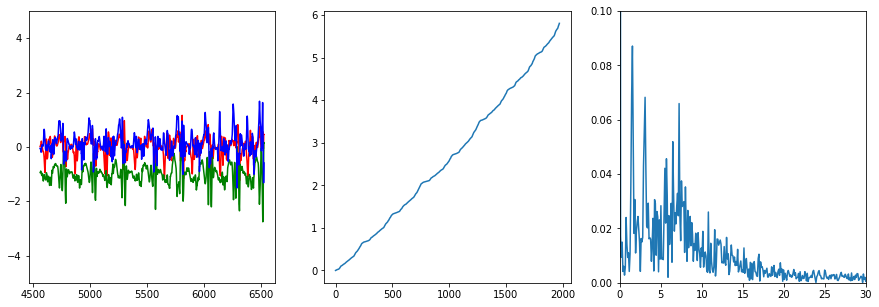

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude              3.896203
Frequency            210.000000
VelocityAmplitude      5.532721
X_max                  1.935909
Y_max                  0.079728
Names                 22.000000
Name: 61, dtype: float64

ACTION: 1


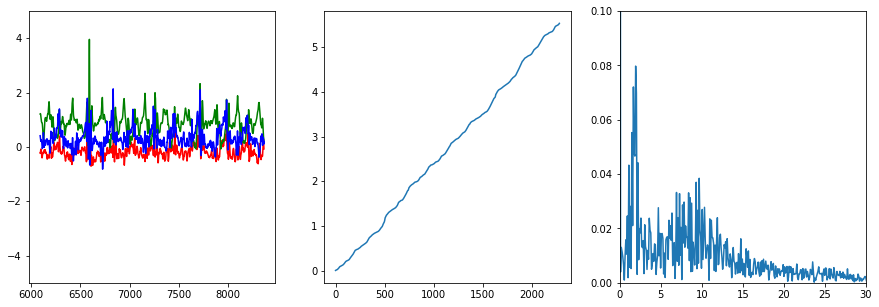

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude              3.083783
Frequency            100.000000
VelocityAmplitude      5.152176
X_max                  1.883239
Y_max                  0.138626
Names                 28.000000
Name: 67, dtype: float64

ACTION: 1


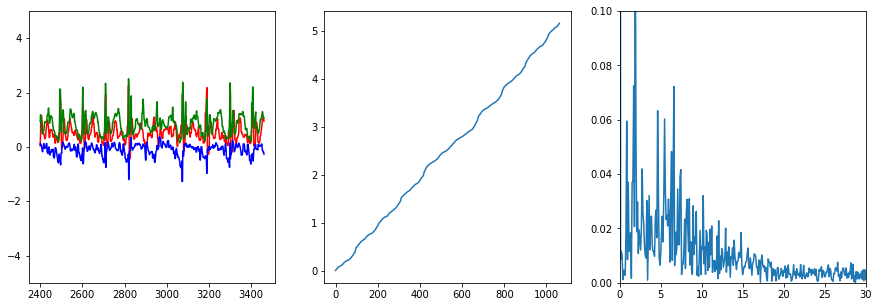

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude              3.579886
Frequency            250.000000
VelocityAmplitude     11.309349
X_max                  1.285093
Y_max                  0.036980
Names                 50.000000
Name: 92, dtype: float64

ACTION: 1


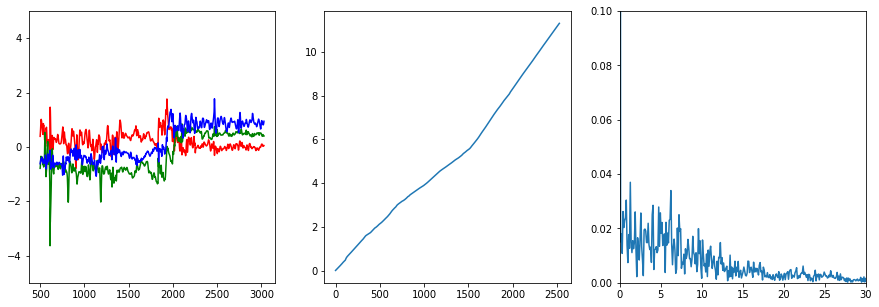

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude              8.699583
Frequency            500.000000
VelocityAmplitude      6.450635
X_max                  1.571092
Y_max                  0.208016
Names                 55.000000
Name: 97, dtype: float64

ACTION: 1


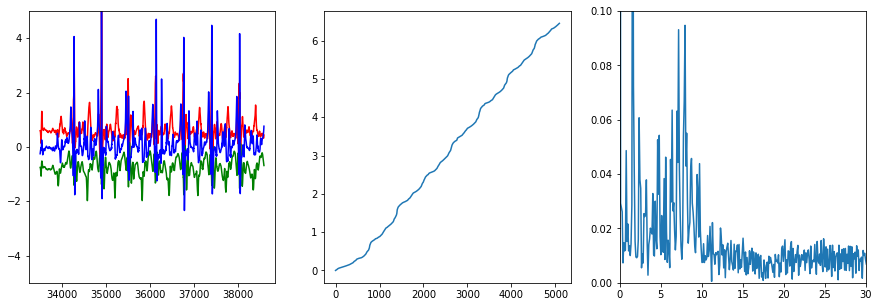

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude             2.384554
Frequency            90.000000
VelocityAmplitude    13.691581
X_max                 0.093555
Y_max                 0.249842
Names                68.000000
Name: 111, dtype: float64

ACTION: 1


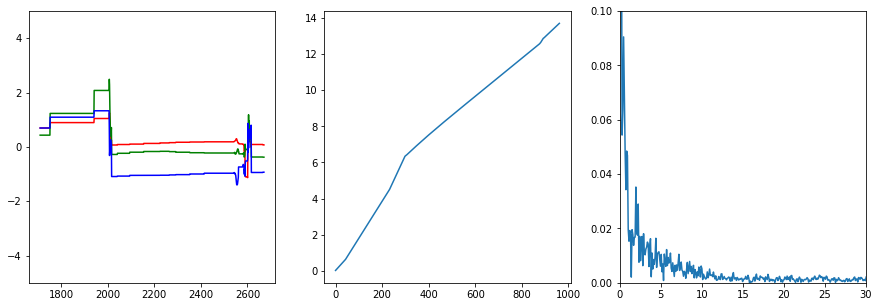

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude              1.190397
Frequency            200.000000
VelocityAmplitude      2.472394
X_max                  1.699150
Y_max                  0.113938
Names                 69.000000
Name: 112, dtype: float64

ACTION: 1


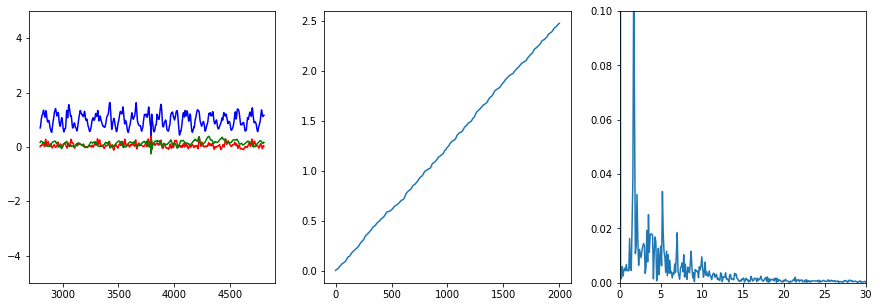

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude              3.657671
Frequency            100.000000
VelocityAmplitude      6.132965
X_max                  1.988636
Y_max                  0.088089
Names                 72.000000
Name: 116, dtype: float64

ACTION: 1


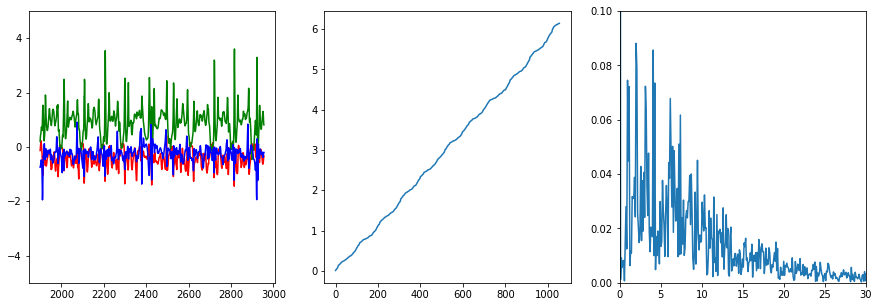

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude             3.216471
Frequency            90.000000
VelocityAmplitude     6.605879
X_max                 1.617336
Y_max                 0.220508
Names                74.000000
Name: 118, dtype: float64

ACTION: 1


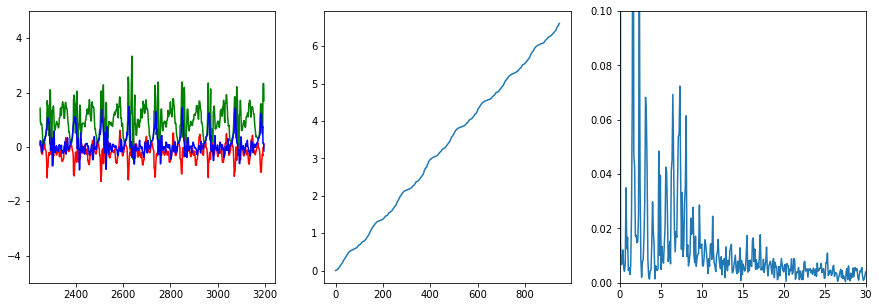

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude              1.858024
Frequency            250.000000
VelocityAmplitude      7.075388
X_max                  2.054795
Y_max                  0.039989
Names                 77.000000
Name: 121, dtype: float64

ACTION: 1


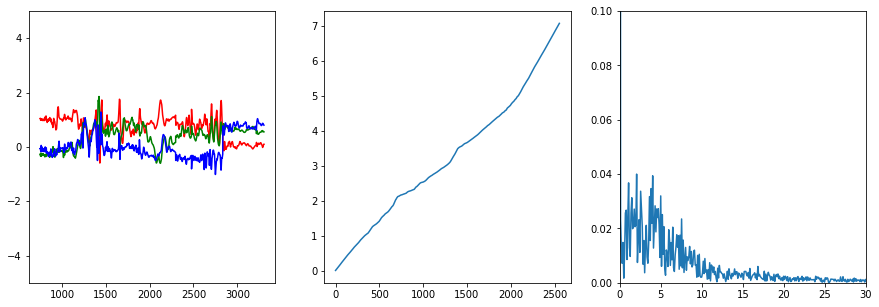

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude              2.161945
Frequency            400.000000
VelocityAmplitude      4.655624
X_max                  1.482213
Y_max                  0.161734
Names                 86.000000
Name: 131, dtype: float64

ACTION: 1


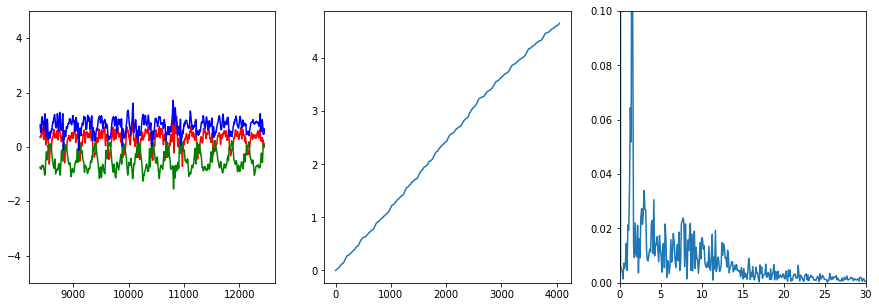

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude              2.200481
Frequency            100.000000
VelocityAmplitude      6.192619
X_max                  1.727447
Y_max                  0.191608
Names                 87.000000
Name: 132, dtype: float64

ACTION: 1


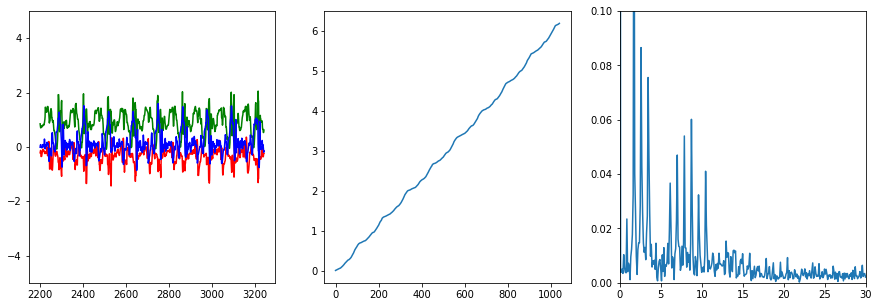

____________________________________________________________________________________________________
____________________________________________________________________________________________________


Amplitude             3.283161
Frequency            90.000000
VelocityAmplitude     7.252354
X_max                 1.386037
Y_max                 0.224386
Names                88.000000
Name: 133, dtype: float64

ACTION: 1


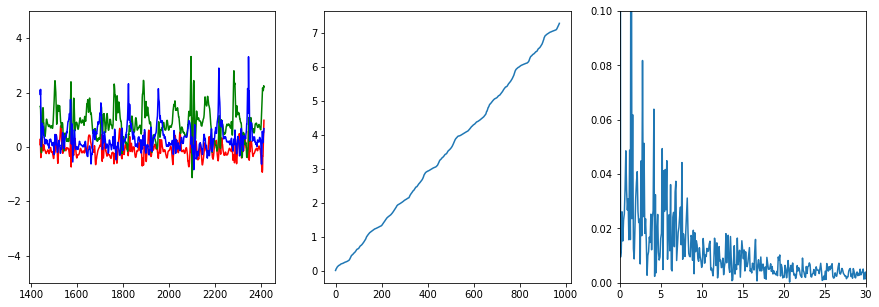

____________________________________________________________________________________________________


In [16]:
track_type = 1
arr = Res[Res['action'] == track_type]['track_num'].tolist()

for k in range(len(Data)):
    if Names[k] not in arr:
        continue
    
    print('_' * 100)
    
    display(data.iloc[Names[k]])
    print('ACTION:', Res.iloc[Names[k]]['action'], sep=' ')
    
    fig, ((ax1, ax2, ax3))= plt.subplots(nrows=1, ncols=3, figsize=(15,5))

    # отрисовываем измерения по каждой оси
    ax1.plot(Data[k]['gFx'], color='r')
    ax1.plot(Data[k]['gFy'], color='g')
    ax1.plot(Data[k]['gFz'], color='b')
    ax1.set_ylim(-5, 5)
    # отрисовываем график скорости
    ax2.plot(Velocity[k])
    # отрисовываем FFT
    n = Data[k].shape[0]
    T = n / Frequency[k]    
    ax3.plot((np.arange(n) / T)[:n // 2], FFT_acc[k])
    ax3.set_xlim(0, 30)
    ax3.set_ylim(0, 0.1)

    plt.show()

    print('_' * 100)